In [18]:
# General
import numpy as np
import pandas as pd
import os

# For loading data and feature engineering
import sys
sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')
from feature_set_v2 import MergedDataLoader


# For data prep and pre-processing
from jumpmodels.utils import filter_date_range 
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from sklearn.preprocessing import StandardScaler

# For model fit and prediction
from joblib import Parallel, delayed # allows parallel grid search on all 4 cores
from jumpmodels.sparse_jump import SparseJumpModel

# For plotting
from jumpmodels.plot import plot_regimes_and_cumret, plot_cumret
import matplotlib.pyplot as plt

# Portfolio allocation
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier


In [19]:
###############################################################################
# 1) HELPER: EWMA Covariance
###############################################################################
def ewm_covariance(returns: pd.DataFrame, halflife=126, min_periods=1) -> pd.DataFrame:
    """
    Compute an exponentially weighted covariance matrix over all data in 'returns'.
    The half-life is 126 days, meaning weights decay by 50% every 126 days.
    We then select the final NxN slice from the multi-index result.
    """
    ewm_cov = returns.ewm(halflife=halflife, adjust=False, min_periods=min_periods).cov()
    if len(returns) == 0:
        # Return an empty DataFrame if no data
        return pd.DataFrame()
    last_date = returns.index[-1]
    df_slice = ewm_cov.loc[last_date]  # shape (N, N)
    df_slice.index.name = None
    return df_slice

Weights: 
    Factors L/S
    Market L/S

cov_matrix: EWMA

pi: "equal"

In [20]:
###############################################################################
# 2) HELPER: Rolling + Expanding Black–Litterman
###############################################################################
def run_bl_portfolio_pyopt_expanding(
    factor_dict,
    returns_df,
    test_index,
    tau=0.05,
    delta=2.5
):
    """
    An expanding-window Black–Litterman procedure:
    - For each date t in test_index, we take all historical data up to t-1 to compute:
       (a) an EWMA covariance (with half-life=126)
       (b) a BL prior using pi="equal"  (i.e. all assets get equal baseline expected return)
       (c) factor-based relative views: factor vs Market => P, Q
    - Then we get posterior (bl_returns, bl_cov).
    - Then run a standard Efficient Frontier (max_sharpe).
    - We store the resulting weights for day t.
    """
    assets = list(returns_df.columns)   # e.g. [factor1, factor2, ..., Market]
    factors = list(factor_dict.keys())  # e.g. [factor1, factor2, ...]
    weights_df = pd.DataFrame(index=test_index, columns=assets, dtype=float)

    bounds = []
    for asset in assets:
        if asset == "Market":
            bounds.append((-1, 1))  # allow short up to -100%
        else:
            bounds.append((0, 1))   # no shorting these factors

    test_dates = list(test_index)

    # Assign "market caps" equally to each ETF => that implies an equal-weight reference portfolio.
    market_caps = {etf: 1.0 for etf in assets}

    for i, t in enumerate(test_dates):
        # 1) Expand up to day t-1
        window_end_idx = returns_df.index.get_loc(t)
        if window_end_idx == 0:
            # No prior data => skip
            continue
        expanding_slice = returns_df.iloc[:window_end_idx]

        # 2) Compute the EWMA covariance
        cov_matrix = ewm_covariance(expanding_slice, halflife=126, min_periods=60) * 252
        if cov_matrix.empty or cov_matrix.isna().any().any():
            # If invalid, skip
            continue

        # 3) Construct absolute views from factor regimes
        viewdict = {}
        for fac in factors:
            st = factor_dict[fac]['states'].loc[t]
            daily_abs_ret = factor_dict[fac]['abs_regime_returns'][st]
            annual_abs_ret = daily_abs_ret * 252
            viewdict[fac] = annual_abs_ret

        # 4) Calculate the prior
        prior = market_implied_prior_returns(market_caps, delta, cov_matrix)

        # 5) Build the Black–Litterman model
        try:
            bl = BlackLittermanModel(
                cov_matrix=cov_matrix,
                pi="equal",
                tau=tau,
                delta=delta,
                absolute_views=viewdict,
            )
        except Exception as e:
            print(f"BL Model error on day {t}: {e}")
            continue

        # 6) Retrieve posterior returns & covariance
        mu_bl = bl.bl_returns()
        cov_bl = bl.bl_cov()

        # 7) Mean-variance optimization
        ef = EfficientFrontier(mu_bl, cov_matrix, weight_bounds=bounds)
        try:
            ef.max_sharpe()
        except Exception as e:
            print(f"Optimization error on day {t}: {e}")
            continue

        # 8) Store weights for day t (no one-day lag)
        w_series = pd.Series(ef.clean_weights(), name=t)
        weights_df.loc[t] = w_series

    return weights_df


In [21]:
# ---------------------------------------------------------------------
# Sharpe Ratio
# ---------------------------------------------------------------------
def annualized_sharpe(r):
    return (r.mean() / r.std()) * np.sqrt(252)

In [22]:
def run_trading_with_saved_hyperparams(
    factor_data_dict,
    saved_hyperparams,
    factors,
    test_index,
    full_df,
    REFIT_FREQ="ME",
    MIN_TRAINING_YEARS=8,
    MAX_TRAINING_YEARS=12,
    INITIAL_TRAIN_START="2002-05-31"
):
    """
    Run trading strategy using pre-computed hyperparameters without re-doing cross-validation.
    
    Parameters:
        factor_data_dict: Dictionary containing factor data
        saved_hyperparams: Dictionary with saved hyperparameters from previous run
        factors: List of factor names
        test_index: DatetimeIndex for the test period
        full_df: DataFrame with all factor returns and market returns
        REFIT_FREQ: Frequency of model refitting
        MIN_TRAINING_YEARS: Minimum years for training window
        MAX_TRAINING_YEARS: Maximum years for training window
        INITIAL_TRAIN_START: Start date of initial training window
    
    Returns:
        Dictionary containing performance results
    """
    # Define refit boundaries
    refit_boundaries = (
        test_index.to_series()
        .resample(REFIT_FREQ)
        .last()
        .dropna()
    )
    
    # Tracking variables
    all_daily_states = {fac: pd.Series(dtype=float) for fac in factors}
    all_daily_weights = []
    all_daily_rets = []
    
    # Helper function for get_train_val_windows (same as in original code)
    def get_train_window(
        current_date, 
        full_data, 
        min_train_years=MIN_TRAINING_YEARS,
        max_train_years=MAX_TRAINING_YEARS,
        initial_train_start=INITIAL_TRAIN_START
    ):
        # Training window ends at current date
        train_end = current_date
        
        # Try the largest training window (max_train_years)
        train_start_candidate = train_end - pd.DateOffset(years=max_train_years)
        
        # Don't go before global earliest start
        if initial_train_start is not None:
            earliest_start_dt = pd.to_datetime(initial_train_start)
            train_start_candidate = max(train_start_candidate, earliest_start_dt)
        
        # Ensure we have at least min_train_years
        if (train_end - train_start_candidate) < pd.Timedelta(days=365.25 * min_train_years):
            train_start_candidate = train_end - pd.DateOffset(years=min_train_years)
            if initial_train_start is not None:
                train_start_candidate = max(train_start_candidate, earliest_start_dt)
        
        # Filter actual data
        idx = full_data.index
        train_dates = idx[(idx >= train_start_candidate) & (idx <= train_end)]
        
        if len(train_dates) == 0:
            raise ValueError(
                f"No data found for train [{train_start_candidate} to {train_end}]"
            )
        
        return train_dates[0], train_dates[-1]
    
    # Process each refit period
    for j in range(len(refit_boundaries)):
        refit_date = refit_boundaries.iloc[j]
        
        # Define the trading period
        if j < len(refit_boundaries) - 1:
            next_refit_date = refit_boundaries.iloc[j + 1]
        else:
            # For the last refit period, use end of data
            next_refit_date = test_index[-1]
        
        test_mask = (test_index > refit_date) & (test_index <= next_refit_date)
        test_dates_chunk = test_index[test_mask]
        
        if len(test_dates_chunk) == 0:
            continue
                
        print(f"\nTrading period: {refit_date} to {next_refit_date} ({len(test_dates_chunk)} days)")
        
        # Build factor dict for BL portfolio construction
        factor_dict_chunk = {}
        
        # Process each factor for this refit period
        for fac in factors:
            # Get the appropriate hyperparameters for this factor
            # Find the most recent hyperparameter setting prior to or at the refit date
            fac_params = saved_hyperparams[fac]
            param_dates = [pd.to_datetime(entry['date']) for entry in fac_params]
            param_dates = [d for d in param_dates if d <= refit_date]
            
            if not param_dates:
                print(f"No saved hyperparameters found for {fac} before {refit_date}")
                continue
                
            most_recent_param_date = max(param_dates)
            hyperparams = next(entry for entry in fac_params 
                              if pd.to_datetime(entry['date']) == most_recent_param_date)
            
            lam = hyperparams['new_lambda']
            kp = hyperparams['new_kappa']
            
            print(f"Using hyperparameters for {fac}: lambda={lam:.2f}, kappa={kp:.2f} (from {most_recent_param_date})")
            
            # Get data for this factor
            fac_data = factor_data_dict[fac]
            X = fac_data["X"]
            ret_full = fac_data["fac_ret"]
            mkt_full = fac_data["mkt_ret"]
            active = fac_data["active_ret"]
            
            # Get appropriate training window for this refit date
            train_start, train_end = get_train_window(
                refit_date, X,
                min_train_years=MIN_TRAINING_YEARS,
                max_train_years=MAX_TRAINING_YEARS,
                initial_train_start=INITIAL_TRAIN_START
            )
            
            # Get training data
            X_train = filter_date_range(X, start_date=train_start, end_date=train_end)
            active_train = filter_date_range(active, start_date=train_start, end_date=train_end)
            factor_returns_train = filter_date_range(ret_full, start_date=train_start, end_date=train_end)

            
            # Process training data
            clipper = DataClipperStd(mul=3.0)
            X_train_clip = clipper.fit_transform(X_train)
            
            scaler = StandardScaler()
            X_train_scaled = pd.DataFrame(
                scaler.fit_transform(X_train_clip),
                index=X_train_clip.index,
                columns=X_train_clip.columns
            )
            
            # Fit SJM with saved hyperparameters
            max_feats = int(kp**2)
            sjm = SparseJumpModel(
                n_components=2, 
                max_feats=max_feats, 
                jump_penalty=lam
            )
            sjm.fit(X_train_scaled, ret_ser=active_train, sort_by="cumret")
            
            # Daily online inference for trading period
            X_test_proc_list = []
            for day in test_dates_chunk:
                # For online scaling, we use all available history up to the current day
                X_hist = X.loc[:day]
                
                # Clip & scale using all history
                temp_clipper = DataClipperStd(mul=3.0)
                X_hist_clip = temp_clipper.fit_transform(X_hist)
                
                temp_scaler = StandardScaler()
                _ = temp_scaler.fit_transform(X_hist_clip)  # Fit on all history
                
                # Transform just the current day
                if day in X.index:
                    X_day = X.loc[[day]]
                    X_day_clip = temp_clipper.transform(X_day)
                    X_day_scaled = temp_scaler.transform(X_day_clip)
                    X_test_proc_list.append(
                        pd.Series(X_day_scaled.flatten(), index=X_day.columns, name=day)
                    )
            
            X_test_scaled = pd.DataFrame(X_test_proc_list).sort_index()
            
            # Predict states
            # Old:
            # if not X_test_scaled.empty:
            #     states_chunk = sjm.predict_online(X_test_scaled)
            #     states_series = pd.Series(states_chunk, index=X_test_scaled.index)
            # else:
            #     states_series = pd.Series(dtype=float)
            
            # New:
            if X_test_scaled.empty:
                raise ValueError(f"No scaled data available for prediction on trading dates: {test_dates_chunk[0]} to {test_dates_chunk[-1]}")
                
            states_chunk = sjm.predict_online(X_test_scaled)
            states_series = pd.Series(states_chunk, index=X_test_scaled.index)
            
            # Update global state tracking
            all_daily_states[fac] = pd.concat(
                [s for s in [all_daily_states[fac], states_series] if not s.empty]
            ).sort_index()
            
            train_states = sjm.predict(X_train_scaled)
            train_state_series = pd.Series(train_states, index=X_train_scaled.index)

            abs_regime_returns = {}
            for st in range(sjm.n_components):
                st_dates = train_state_series[train_state_series == st].index
                abs_regime_returns[st] = factor_returns_train.loc[st_dates].mean()


            # Store factor info for BL
            factor_dict_chunk[fac] = {
                "ret": ret_full,
                "states": states_series,
                "regime_returns": {
                    0: sjm.ret_[0],
                    1: sjm.ret_[1],
                },
                "abs_regime_returns" : {
                    0: abs_regime_returns[0],
                    1: abs_regime_returns[1],
                }
            }
            
        
        # Run Black-Litterman portfolio construction with your modified version
        weights_chunk = run_bl_portfolio_pyopt_expanding(
            factor_dict=factor_dict_chunk,
            returns_df=full_df,
            test_index=test_dates_chunk,
            tau=0.05,  # You can modify these parameters as needed
            delta=2.5   # for your BL changes
        )
        
        # Compute portfolio returns
        daily_factor_rets = full_df.loc[test_dates_chunk, factors]
        portfolio_rets = (weights_chunk * daily_factor_rets).sum(axis=1)
        
        # Store results
        all_daily_weights.append(weights_chunk)
        all_daily_rets.append(portfolio_rets)
    
    # Combine all results
    if len(all_daily_rets) == 0:
        raise ValueError("No daily returns computed. Check your date ranges or data.")

    all_portfolio_rets = pd.concat(all_daily_rets).sort_index()
    all_weights_df = pd.concat(all_daily_weights).sort_index()
    
    return {
        "returns": all_portfolio_rets,
        "weights": all_weights_df,
        "states": all_daily_states
    }

In [23]:
def format_saved_hyperparameters(hyperparameter_history):
    """
    Format the hyperparameter history into a structured format
    for easier lookup during trading.
    """
    # Convert the format to be more suitable for lookup
    formatted_params = {}
    
    for factor, history in hyperparameter_history.items():
        formatted_params[factor] = history
        
    return formatted_params

In [24]:
hyperparameter_history = {
    'iwf': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 194.44444444444446, 'old_kappa': None, 'new_kappa': 2.802775637731995, 'sharpe': -0.00040810662925682057},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 194.44444444444446, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.17071973179690386},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.3578102263098243},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.4841917963037153},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 358.8888888888889, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.0021833092539811937},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 400.0, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': -0.08661718291998324},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 400.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.04537836286365537},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 400.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.3796416073101208},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 400.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.3143905966885326},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 71.11111111111111, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.6565757223197191},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 30.0, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5661972679926426},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 194.44444444444446, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5025574640511644},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 194.44444444444446, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.4412874588946835},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.6244571972898924},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5496996539335203},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5045344785461053},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 153.33333333333334, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.6748125011222248},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5220707952568912}
    ],
    'mtum': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 153.33333333333334, 'old_kappa': None, 'new_kappa': 3.605551275463989, 'sharpe': 0.9737531059727994},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 71.11111111111111, 'old_kappa': 3.605551275463989, 'new_kappa': 2.0, 'sharpe': 1.2385288514186117},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 71.11111111111111, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.5384280936967225},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 71.11111111111111, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.2449318483644662},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.2849216385777595},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.3550258164181153},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.2946985716778718},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.2443701401904304},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 30.0, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.0609358262039597},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 317.7777777777778, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.5336681869528377},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 71.11111111111111, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.42085014436258855},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 71.11111111111111, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.4776764452885165},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.29425697780975163},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.12389367197312393},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 235.55555555555557, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.30857404399436067},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 358.8888888888889, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.39916193058999083},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 276.6666666666667, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.29269886811293266},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.48260717116695645}
    ],
    'qual': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 112.22222222222223, 'old_kappa': None, 'new_kappa': 2.0, 'sharpe': -0.008942944608080107},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 194.44444444444446, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.3729840213884896},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 276.6666666666667, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.4569557693250369},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 276.6666666666667, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.46645808224234},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 317.7777777777778, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.44970951739981563},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.4565696219766751},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 276.6666666666667, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.515467869569287},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 30.0, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.34082022634710635},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.43043837227656606},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 235.55555555555557, 'old_kappa': 3.605551275463989, 'new_kappa': 2.0, 'sharpe': 0.48545612296409024},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 235.55555555555557, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.24680166988096894},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 194.44444444444446, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.3768471604383053},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 235.55555555555557, 'old_kappa': 2.0, 'new_kappa': 3.605551275463989, 'sharpe': 0.52515080472428},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 276.6666666666667, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.5032881257329227},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 276.6666666666667, 'old_kappa': 3.605551275463989, 'new_kappa': 2.0, 'sharpe': 0.5601170142538924},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 30.0, 'old_kappa': 2.0, 'new_kappa': 3.605551275463989, 'sharpe': 0.6556926212774876},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.6397538574423197},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.595839463815995}
    ],
    'size': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 30.0, 'old_kappa': None, 'new_kappa': 3.605551275463989, 'sharpe': 0.18325758924372446},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.35998093208599363},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.20754182203863084},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.169026897105994},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.170613601033382},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.08232751636587375},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 194.44444444444446, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.07975853398451298},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 194.44444444444446, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.20993440803949895},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 235.55555555555557, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.16038247250831156},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 317.7777777777778, 'old_kappa': 3.605551275463989, 'new_kappa': 2.0, 'sharpe': -0.018202918861167948},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 400.0, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.036480646039279585},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.36563761781827314},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 317.7777777777778, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.32185546293215544},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 317.7777777777778, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.2798812792489098},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': 0.452087066336667},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 358.8888888888889, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.5006537077202152},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 317.7777777777778, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.5716957249478238},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 317.7777777777778, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.4431237089045836}
    ],
    'usmv': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 30.0, 'old_kappa': None, 'new_kappa': 2.0, 'sharpe': -0.018377230113554608},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 400.0, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.22709101622189878},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 194.44444444444446, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': -0.11574479947038052},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 194.44444444444446, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': -0.13169461167089427},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 194.44444444444446, 'new_lambda': 112.22222222222223, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': -0.04023257907985476},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 71.11111111111111, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': -0.09485108586318038},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 71.11111111111111, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': -0.20505014291457693},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.0, 'new_kappa': 2.802775637731995, 'sharpe': -0.21124341082069295},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.27357211138032833},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.12318043827830945},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': -0.027488565563862734},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.00615644148977025},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 276.6666666666667, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.1102054318041255},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.18972149133249572},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.09270063511915752},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 30.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.23279385139850495},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 30.0, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.30721578219158546},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': 0.25005959115900506}
    ],
    'vlue': [
        {'date': pd.Timestamp('2017-01-31 00:00:00'), 'old_lambda': None, 'new_lambda': 112.22222222222223, 'old_kappa': None, 'new_kappa': 2.0, 'sharpe': 0.9808698623368385},
        {'date': pd.Timestamp('2017-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 317.7777777777778, 'old_kappa': 2.0, 'new_kappa': 3.605551275463989, 'sharpe': 0.8394277858533714},
        {'date': pd.Timestamp('2018-01-31 00:00:00'), 'old_lambda': 317.7777777777778, 'new_lambda': 276.6666666666667, 'old_kappa': 3.605551275463989, 'new_kappa': 2.0, 'sharpe': 1.006140466878844},
        {'date': pd.Timestamp('2018-07-31 00:00:00'), 'old_lambda': 276.6666666666667, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.0366275635711821},
        {'date': pd.Timestamp('2019-01-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 112.22222222222223, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 1.0882139211247348},
        {'date': pd.Timestamp('2019-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 358.8888888888889, 'old_kappa': 2.0, 'new_kappa': 3.605551275463989, 'sharpe': 0.6059643491080812},
        {'date': pd.Timestamp('2020-01-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 358.8888888888889, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.39346946308603115},
        {'date': pd.Timestamp('2020-07-31 00:00:00'), 'old_lambda': 358.8888888888889, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.350841470339303},
        {'date': pd.Timestamp('2021-01-29 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 153.33333333333334, 'old_kappa': 3.605551275463989, 'new_kappa': 3.605551275463989, 'sharpe': 0.4540450646485634},
        {'date': pd.Timestamp('2021-07-30 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 235.55555555555557, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.45721111621311916},
        {'date': pd.Timestamp('2022-01-31 00:00:00'), 'old_lambda': 235.55555555555557, 'new_lambda': 112.22222222222223, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.4393294952136704},
        {'date': pd.Timestamp('2022-07-29 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 2.802775637731995, 'sharpe': 0.538921576147189},
        {'date': pd.Timestamp('2023-01-31 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 112.22222222222223, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.3856975910925221},
        {'date': pd.Timestamp('2023-07-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 153.33333333333334, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.3300623151991221},
        {'date': pd.Timestamp('2024-01-31 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 153.33333333333334, 'old_kappa': 2.802775637731995, 'new_kappa': 3.605551275463989, 'sharpe': 0.31531828237806936},
        {'date': pd.Timestamp('2024-07-31 00:00:00'), 'old_lambda': 153.33333333333334, 'new_lambda': 112.22222222222223, 'old_kappa': 3.605551275463989, 'new_kappa': 2.802775637731995, 'sharpe': 0.22277643742023429},
        {'date': pd.Timestamp('2025-01-31 00:00:00'), 'old_lambda': 112.22222222222223, 'new_lambda': 400.0, 'old_kappa': 2.802775637731995, 'new_kappa': 2.0, 'sharpe': -0.059024223017440335},
        {'date': pd.Timestamp('2025-04-03 00:00:00'), 'old_lambda': 400.0, 'new_lambda': 400.0, 'old_kappa': 2.0, 'new_kappa': 2.0, 'sharpe': 0.05808658892901897}
    ]
}



Loading data for factor iwf

Loading data for factor mtum

Loading data for factor qual

Loading data for factor size

Loading data for factor usmv

Loading data for factor vlue

Trading period: 2017-01-31 00:00:00 to 2017-02-28 00:00:00 (19 days)
Using hyperparameters for iwf: lambda=194.44, kappa=2.80 (from 2017-01-31 00:00:00)
Using hyperparameters for mtum: lambda=153.33, kappa=3.61 (from 2017-01-31 00:00:00)
Using hyperparameters for qual: lambda=112.22, kappa=2.00 (from 2017-01-31 00:00:00)
Using hyperparameters for size: lambda=30.00, kappa=3.61 (from 2017-01-31 00:00:00)
Using hyperparameters for usmv: lambda=30.00, kappa=2.00 (from 2017-01-31 00:00:00)
Using hyperparameters for vlue: lambda=112.22, kappa=2.00 (from 2017-01-31 00:00:00)

Trading period: 2017-02-28 00:00:00 to 2017-03-31 00:00:00 (23 days)
Using hyperparameters for iwf: lambda=194.44, kappa=2.80 (from 2017-01-31 00:00:00)
Using hyperparameters for mtum: lambda=153.33, kappa=3.61 (from 2017-01-31 00:00:00)
Using

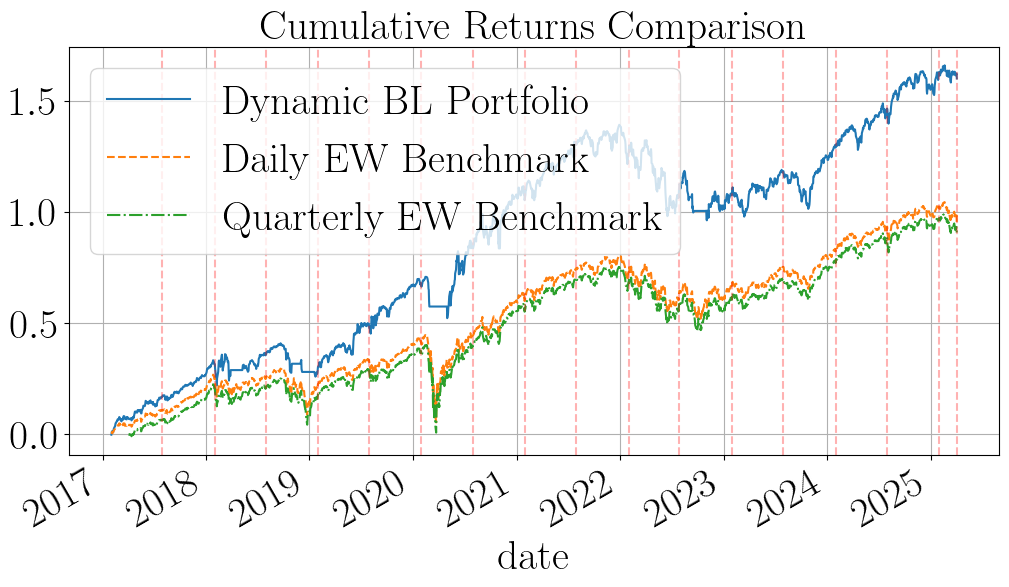

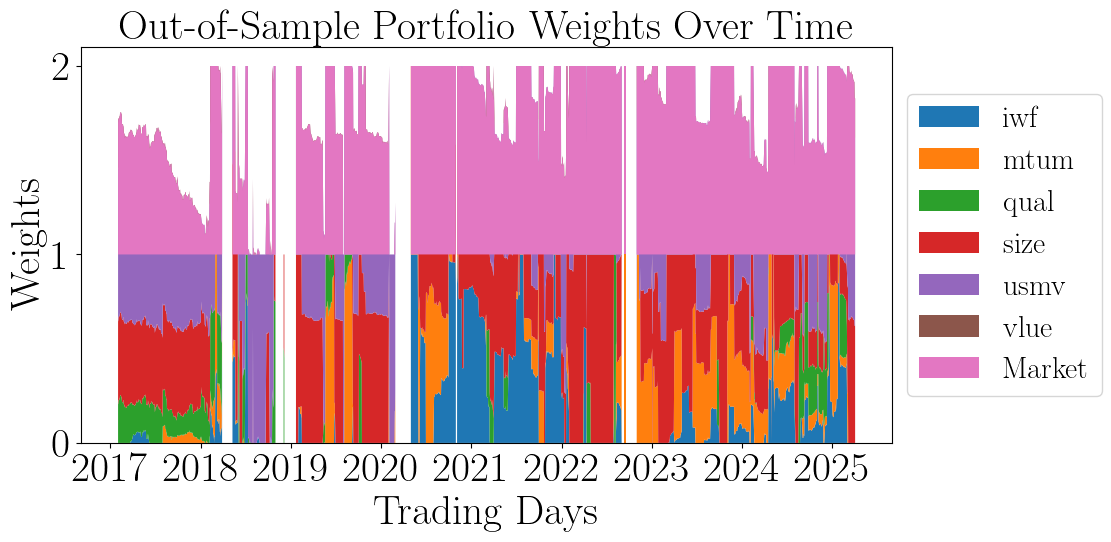


PERFORMANCE SUMMARY
Period: 2017-02-01 00:00:00 to 2025-04-03 00:00:00
Number of trading days: 2056

Annualized Performance Metrics:
Daily EW Benchmark Sharpe: 0.6806
Quarterly EW Benchmark Sharpe: 0.6496
Dynamic BL Portfolio Sharpe: 0.9659

Total Returns:
Daily EW Benchmark Return: 0.9452
Quarterly EW Benchmark Return: 0.8927
Dynamic BL Portfolio Return: 1.5995


In [ ]:


    # Modified main function for more efficient processing
    if __name__ == "__main__":
        ############################################################################
        # 0) Set parameters
        ############################################################################
        # We define how often to re-fit and re-cross-validate:
        REFIT_FREQ = "ME"  # Monthly refit
        RECROSS_VAL_FREQ = "6ME"  # Every 6 months recross-validation
        
        # Training window configuration
        MIN_TRAINING_YEARS = 8  # Minimum 8 years of training data
        MAX_TRAINING_YEARS = 12  # Maximum 12 years of training data
        VAL_YEARS = 6  # 6-year validation window
        
        # Paths & Tickers
        script_dir = os.getcwd()
        base_dir = os.path.abspath(os.path.join(script_dir, "..", "..", ".."))
        data_dir = os.path.join(base_dir, "data_new")
        factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
        market_file = os.path.join(data_dir, "1macro_data.csv")

        factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]

        # Date boundaries
        INITIAL_TRAIN_START = "2002-05-31"
        test_start = "2017-01-01"

        # Cross-validation settings
        lambda_values = np.linspace(30, 400, 10)  # For grid search
        
        ############################################################################
        # 1) Load full data for all factors & market
        ############################################################################
        # We'll store each factor's entire X and returns in a dict for easy access
        factor_data_dict = {}
        factor_returns_list = []
        for fac in factors:
            print(f"\nLoading data for factor {fac}")
            data = MergedDataLoader(
                factor_file=factor_file,
                market_file=market_file,
                ver="v2",
                factor_col=fac
            ).load()
            common_idx = (
                data.X.index
                .intersection(data.ret_ser.index)
                .intersection(data.market_ser.index)
            )

            # Full factor data
            X_full = data.X.loc[common_idx]
            fac_ret_full = data.ret_ser.loc[common_idx]
            mkt_ret_full = data.market_ser.loc[common_idx]
            active_ret = fac_ret_full - mkt_ret_full ################################################################################## we can access with attribute

            factor_data_dict[fac] = {
                "X": X_full,
                "fac_ret": fac_ret_full,
                "mkt_ret": mkt_ret_full,
                "active_ret": active_ret
            }
            factor_returns_list.append(fac_ret_full)

        # We'll store the last loaded "mkt_ret_full" as "all_market_ret"
        all_market_ret = mkt_ret_full

        # Combine factor returns + market into a single DF
        full_factors_df = pd.concat(factor_returns_list, axis=1).dropna()  # T x 6
        full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
        full_df.columns = factors + ["Market"]

        # Our "test_index" is from test_start onward
        test_slice = filter_date_range(full_df, start_date=test_start)
        test_index = test_slice.index.sort_values()

        # Define refit and re-cross-validation boundaries
        refit_boundaries = (
            test_index.to_series()
            .resample(REFIT_FREQ)
            .last()
            .dropna()
        )
        
        recross_val_boundaries = (
            test_index.to_series()
            .resample(RECROSS_VAL_FREQ)
            .last()
            .dropna()
        )

        # Helper function to get appropriate training and validation windows
        def get_train_val_windows(
            current_date, 
            full_data, 
            min_train_years=8,
            max_train_years=12, 
            val_years=6,
            initial_train_start=None
        ):
            # 1) Validation window
            val_end = current_date
            val_start = val_end - pd.DateOffset(years=val_years)
            
            # 2) Training window ends just before validation
            train_end = val_start - pd.DateOffset(days=1)
            
            # 3) By default, try the *largest* training window (max_train_years)
            train_start_candidate = train_end - pd.DateOffset(years=max_train_years)
            
            # 4) Don’t go before your global earliest start
            if initial_train_start is not None:
                earliest_start_dt = pd.to_datetime(initial_train_start)
                train_start_candidate = max(train_start_candidate, earliest_start_dt)
            
            # 5) Ensure we have at least min_train_years from train_start to train_end
            if (train_end - train_start_candidate) < pd.Timedelta(days=365.25 * min_train_years):
                # Move train_start_candidate to enforce minimum
                train_start_candidate = train_end - pd.DateOffset(years=min_train_years)
                # Also don’t go before earliest global date
                if initial_train_start is not None:
                    train_start_candidate = max(train_start_candidate, earliest_start_dt)
            
            # Filter actual data
            idx = full_data.index
            train_dates = idx[(idx >= train_start_candidate) & (idx <= train_end)]
            val_dates   = idx[(idx >= val_start) & (idx <= val_end)]
            
            if len(train_dates) == 0 or len(val_dates) == 0:
                raise ValueError(
                    f"No data found for train [{train_start_candidate} to {train_end}]"
                    f" or val [{val_start} to {val_end}]"
                )
            
            return train_dates[0], train_dates[-1], val_dates[0], val_dates[-1]


        ############################################################################
        # 2) Main Trading Loop with Periodic Re-Cross-Validation
        ############################################################################
        
        saved_hyperparams = format_saved_hyperparameters(hyperparameter_history)
        
        # Run trading with saved hyperparameters
        results = run_trading_with_saved_hyperparams(
            factor_data_dict=factor_data_dict,
            saved_hyperparams=saved_hyperparams,
            factors=factors,
            test_index=test_index,
            full_df=full_df,
            REFIT_FREQ=REFIT_FREQ,
            MIN_TRAINING_YEARS=MIN_TRAINING_YEARS,
            MAX_TRAINING_YEARS=MAX_TRAINING_YEARS,
            INITIAL_TRAIN_START=INITIAL_TRAIN_START
        )
        
        
        ############################################################################
        # 3) Analyze Results and Compare to Benchmarks
        ############################################################################
        if len("returns") == 0:
            raise ValueError("No daily returns computed. Check your date ranges or data.")

        all_portfolio_rets = results["returns"]
        all_weights_df = results["weights"]
        all_daily_states = results["states"]  # If you need this for analysis
        cumrets = all_portfolio_rets.cumsum()

        # Compare to equal-weight benchmark
        overlap_idx = all_portfolio_rets.index.intersection(full_df.index)
        test_returns_df = full_df.loc[overlap_idx, :]
        ew_bench_rets = test_returns_df.mean(axis=1)
        ew_bench_cum = ew_bench_rets.cumsum()
        
        # Also compute quarterly-rebalanced EW portfolio
        quarterly_ends = test_returns_df.index.to_series().resample("QE").last().dropna()
        n_assets = test_returns_df.shape[1]
        quarterly_ew_rets = pd.Series(index=test_returns_df.index, dtype=float)

        for i in range(len(quarterly_ends) - 1):
            start_q = quarterly_ends.iloc[i]
            end_q = quarterly_ends.iloc[i + 1]
            mask = (test_returns_df.index > start_q) & (test_returns_df.index <= end_q)
            chunk_dates = test_returns_df.index[mask]
            
            w = np.ones(n_assets) / n_assets
            
            for day in chunk_dates:
                r_i = test_returns_df.loc[day].values
                r_p = np.dot(w, r_i)
                quarterly_ew_rets.loc[day] = r_p
                
                w = w * (1 + r_i)
                if (1 + r_p) != 0:
                    w /= (1 + r_p)

        quarterly_ew_rets = quarterly_ew_rets.dropna()
        quarterly_ew_cum = quarterly_ew_rets.cumsum()

        ############################################################################
        # 4) Plot Results and Print Performance Statistics
        ############################################################################
        # Plot 1: Cumulative returns comparison
        plt.figure(figsize=(12, 6))
        cumrets.plot(label="Dynamic BL Portfolio")
        ew_bench_cum.plot(label="Daily EW Benchmark", linestyle="--")
        quarterly_ew_cum.plot(label="Quarterly EW Benchmark", linestyle="-.")
        
        # Add vertical lines at re-cross-validation dates
        for date in recross_val_boundaries:
            if date in cumrets.index:
                plt.axvline(x=date, color='r', linestyle='--', alpha=0.3, 
                            label="Re-Cross-Validation" if date == recross_val_boundaries.iloc[0] else "")
        
        plt.title("Cumulative Returns Comparison")
        plt.legend()
        plt.grid(True)
        plt.show()

        # Factor weights over time
        plt.figure(figsize=(12, 6))
        plt.stackplot(all_weights_df.index, all_weights_df.T.values, labels=all_weights_df.columns)
        plt.title("Out-of-Sample Portfolio Weights Over Time")
        plt.xlabel("Trading Days")
        plt.ylabel("Weights")
        plt.legend(
            loc="center left",
            bbox_to_anchor=(1, 0.5),
            fontsize='small'  # smaller font size for legend
        )

        plt.tight_layout()
        plt.show()


        # Print performance statistics
        print("\n==============================================================")
        print("PERFORMANCE SUMMARY")
        print("==============================================================")
        print(f"Period: {all_portfolio_rets.index[0]} to {all_portfolio_rets.index[-1]}")
        print(f"Number of trading days: {len(all_portfolio_rets)}")
        print("\nAnnualized Performance Metrics:")
        print(f"Daily EW Benchmark Sharpe: {annualized_sharpe(ew_bench_rets):.4f}")
        print(f"Quarterly EW Benchmark Sharpe: {annualized_sharpe(quarterly_ew_rets):.4f}")
        print(f"Dynamic BL Portfolio Sharpe: {annualized_sharpe(all_portfolio_rets):.4f}")
        print(f"\nTotal Returns:")
        print(f"Daily EW Benchmark Return: {ew_bench_cum.iloc[-1]:.4f}")
        print(f"Quarterly EW Benchmark Return: {quarterly_ew_cum.iloc[-1]:.4f}")
        print(f"Dynamic BL Portfolio Return: {cumrets.iloc[-1]:.4f}")

In [26]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

def get_spy_data(start_date, end_date):
    """
    Download SPY data from yfinance between start_date and end_date.
    Returns a DataFrame with daily adjusted close returns and cumulative returns.
    If the download fails or returns an empty DataFrame, returns None.
    """
    try:
        spy_df = yf.download("SPY", start=start_date, end=end_date, progress=False)
        if spy_df.empty:
            print("SPY data is empty. Verify your date range and internet connection.")
            return None
        # Compute daily returns and cumulative returns for a buy-and-hold strategy
        spy_df["Returns"] = spy_df["Adj Close"].pct_change()
        spy_df["CumRet"] = (1 + spy_df["Returns"]).cumprod() - 1
        return spy_df
    except Exception as e:
        print(f"Error downloading SPY data: {e}")
        return None

# Example dates: use your defined test_start and last date of dynamic portfolio returns.
# Ensure these variables are defined in your environment.
# For instance:
# test_start = "2017-01-01"
# all_portfolio_rets: pd.Series from your dynamic strategy; its index should be dates.
spy_data = get_spy_data(start_date=test_start, end_date=all_portfolio_rets.index[-1])
if spy_data is None or spy_data.empty:
    raise ValueError("Failed to download SPY data. Check your internet connection and date range.")

# Compute cumulative returns for the dynamic portfolio
dynamic_port_cum = (1 + all_portfolio_rets).cumprod() - 1

# Ensure the indices align properly
common_index = dynamic_port_cum.index.intersection(spy_data.index)
if common_index.empty:
    raise ValueError("No overlapping dates between dynamic portfolio returns and SPY data. Verify date ranges.")

dynamic_port_cum_aligned = dynamic_port_cum.loc[common_index]
spy_data_aligned = spy_data.loc[common_index]

# Plot comparison of cumulative returns
plt.figure(figsize=(12, 6))
plt.plot(dynamic_port_cum_aligned.index, dynamic_port_cum_aligned, label="Dynamic BL Portfolio")
plt.plot(spy_data_aligned.index, spy_data_aligned["CumRet"], label="SPY Buy & Hold", linestyle="--")
plt.title("Dynamic BL vs. SPY Buy & Hold")
plt.legend()
plt.grid(True)
plt.show()

# Define a simple annualized Sharpe ratio function (assuming zero risk-free rate)
def annualized_sharpe(returns, freq=252):
    return (returns.mean() * freq) / (returns.std() * np.sqrt(freq)) if returns.std() != 0 else np.nan

spy_returns_aligned = spy_data_aligned["Returns"].dropna()
spy_sharpe = annualized_sharpe(spy_returns_aligned)
dynamic_sharpe = annualized_sharpe(all_portfolio_rets.loc[common_index])

print("\nPerformance Comparison vs. SPY")
print("--------------------------------------------------------------")
print(f"Dynamic BL Portfolio Sharpe: {dynamic_sharpe:.4f}")
print(f"SPY Buy & Hold Sharpe      : {spy_sharpe:.4f}")

# Print total returns only if the aligned DataFrames are not empty
if not dynamic_port_cum_aligned.empty and not spy_data_aligned.empty:
    dyn_total = dynamic_port_cum_aligned.iloc[-1] * 100
    spy_total = spy_data_aligned["CumRet"].iloc[-1] * 100
    print("\nTotal Return (over overlap period)")
    print(f"Dynamic BL Portfolio: {dyn_total:.2f}%")
    print(f"SPY Buy & Hold      : {spy_total:.2f}%")
else:
    print("No data available for computing total returns over the overlap period.")



1 Failed download:
['SPY']: JSONDecodeError('Expecting value: line 1 column 1 (char 0)')


SPY data is empty. Verify your date range and internet connection.


ValueError: Failed to download SPY data. Check your internet connection and date range.

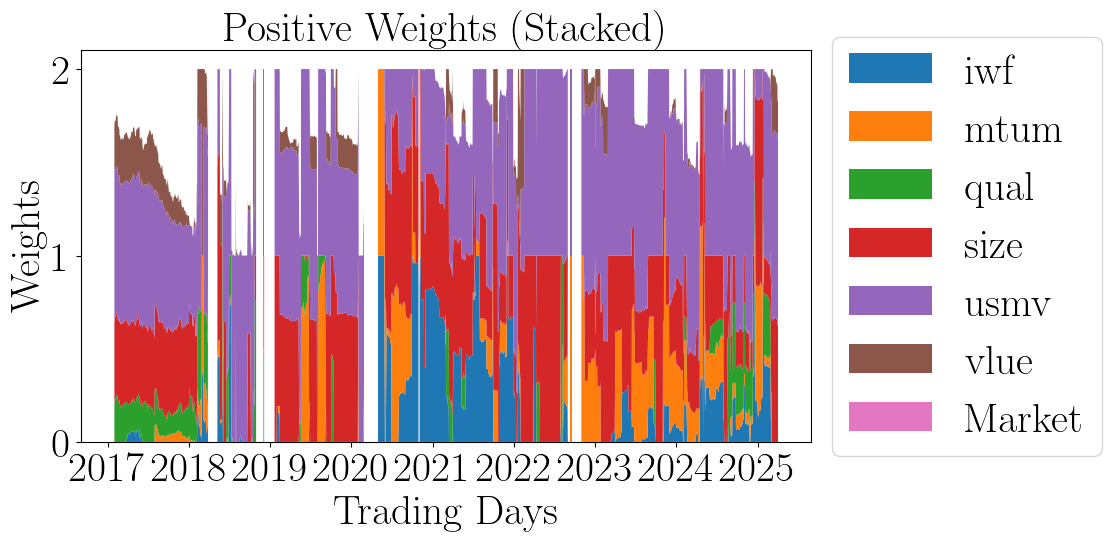

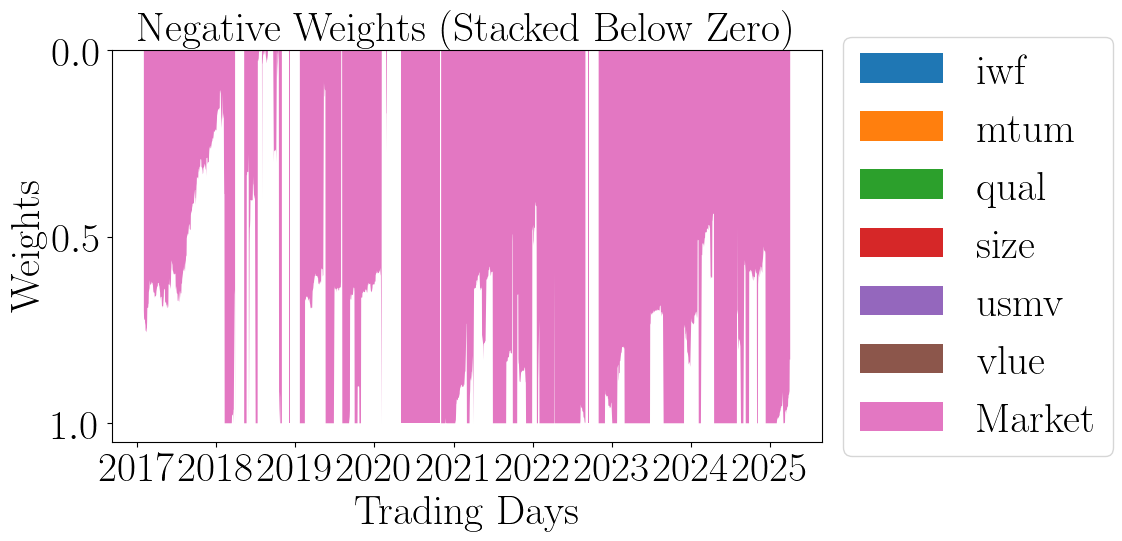

In [28]:
import matplotlib.pyplot as plt

# Split into positive and negative weights
pos_weights = all_weights_df.clip(lower=0)
neg_weights = all_weights_df.clip(upper=0)

# Make a version of the negative weights that is positive (so stackplot can handle it)
neg_weights_abs = -neg_weights

# Plot positive weights
plt.figure(figsize=(12,6))
plt.stackplot(
    pos_weights.index,
    pos_weights.T.values,
    labels=pos_weights.columns
)
plt.title("Positive Weights (Stacked)")
plt.xlabel("Trading Days")
plt.ylabel("Weights")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

# Plot negative weights (inverted)
plt.figure(figsize=(12,6))
plt.stackplot(
    neg_weights_abs.index,
    neg_weights_abs.T.values,
    labels=neg_weights_abs.columns
)
# Invert y-axis so these appear below zero
plt.gca().invert_yaxis()
plt.title("Negative Weights (Stacked Below Zero)")
plt.xlabel("Trading Days")
plt.ylabel("Weights")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()



In [27]:
from scipy import stats

# ======================================================
# For Daily EW Benchmark Comparison:
# ======================================================
# Align the dynamic portfolio and daily EW benchmark returns by their common dates
aligned_bl_daily, aligned_ew_daily = all_portfolio_rets.align(ew_bench_rets, join='inner')

# Paired t-test for daily returns
t_stat_daily, p_value_daily = stats.ttest_rel(aligned_bl_daily, aligned_ew_daily)
print("\nPaired t-test for BL dynamic vs. Daily EW Benchmark:")
print(f"t-statistic: {t_stat_daily:.4f}, p-value: {p_value_daily:.4f}")

# Wilcoxon signed-rank test for daily returns
wilcoxon_stat_daily, wilcoxon_p_daily = stats.wilcoxon(aligned_bl_daily, aligned_ew_daily)
print("\nWilcoxon test for BL dynamic vs. Daily EW Benchmark:")
print(f"Statistic: {wilcoxon_stat_daily:.4f}, p-value: {wilcoxon_p_daily:.4f}")

# ======================================================
# For Quarterly EW Benchmark Comparison:
# ======================================================
# Since both series are daily, if the quarterly benchmark is provided as daily data,
# simply align them by their dates.
aligned_bl_quarterly, aligned_quarterly = all_portfolio_rets.align(quarterly_ew_rets, join='inner')

# Paired t-test for the quarterly EW benchmark (using daily data)
t_stat_quarterly, p_value_quarterly = stats.ttest_rel(aligned_bl_quarterly, aligned_quarterly)
print("\nPaired t-test for BL dynamic vs. Quarterly EW Benchmark:")
print(f"t-statistic: {t_stat_quarterly:.4f}, p-value: {p_value_quarterly:.4f}")

# Wilcoxon signed-rank test for the quarterly EW benchmark
wilcoxon_stat_quarterly, wilcoxon_p_quarterly = stats.wilcoxon(aligned_bl_quarterly, aligned_quarterly)
print("\nWilcoxon test for BL dynamic vs. Quarterly EW Benchmark:")
print(f"Statistic: {wilcoxon_stat_quarterly:.4f}, p-value: {wilcoxon_p_quarterly:.4f}")


Paired t-test for BL dynamic vs. Daily EW Benchmark:
t-statistic: 1.5859, p-value: 0.1129

Wilcoxon test for BL dynamic vs. Daily EW Benchmark:
Statistic: 962473.0000, p-value: 0.0004

Paired t-test for BL dynamic vs. Quarterly EW Benchmark:
t-statistic: 1.5403, p-value: 0.1236

Wilcoxon test for BL dynamic vs. Quarterly EW Benchmark:
Statistic: 926064.0000, p-value: 0.0007


In [ ]:
# # Print hyperparameter evolution
    # print("\n==============================================================")
    # print("HYPERPARAMETER EVOLUTION")
    # print("==============================================================")
    # for fac in factors:
    #     if hyperparameter_history[fac]:
    #         print(f"\nFactor: {fac}")
    #         for entry in hyperparameter_history[fac]:
    #             print(f"Date: {entry['date']}")
    #             #print(f"  Lambda: {entry['old_lambda']:.2f} -> {entry['new_lambda']:.2f}")
    #             print(f"  Kappa²: {int(entry['old_kappa']**2)} -> {int(entry['new_kappa']**2)}")
    #             print(f"  Sharpe: {entry['sharpe']:.4f}")
    #     else:
    #         print(f"\nFactor: {fac} - No parameter changes")

    # # Print training window evolution
    # if training_window_history:
    #     print("\n==============================================================")
    #     print(f"TRAINING WINDOW EVOLUTION ({WINDOW_TYPE.upper()})")
    #     print("==============================================================")
    #     for entry in training_window_history:
    #         print(f"Date: {entry['date']}")
    #         print(f"  Window: {entry['start_date']} to {entry['end_date']}")
    #         print(f"  Size: {entry['years']:.2f} years")

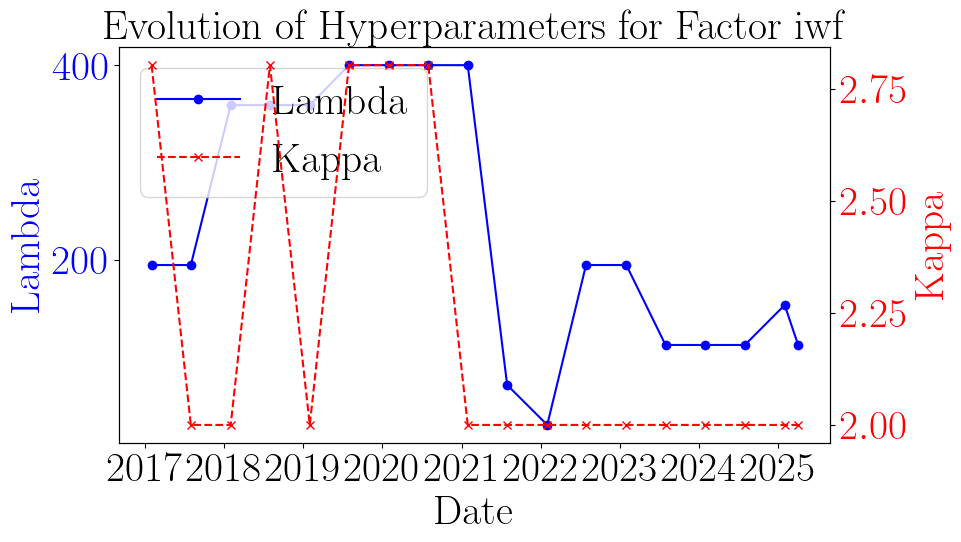

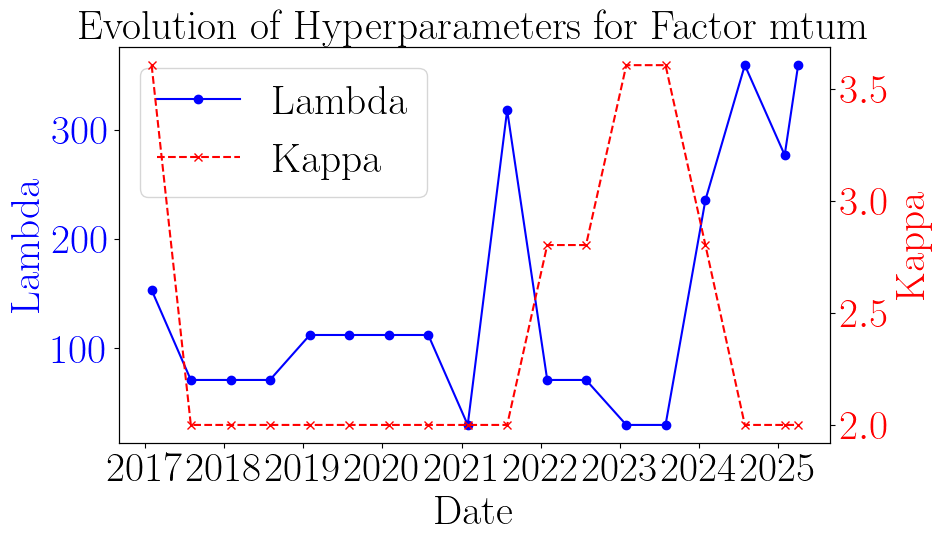

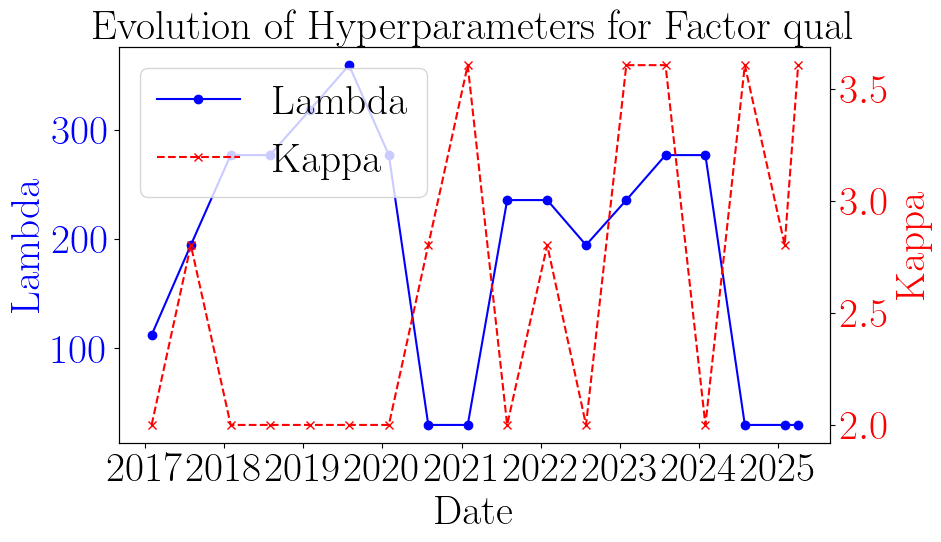

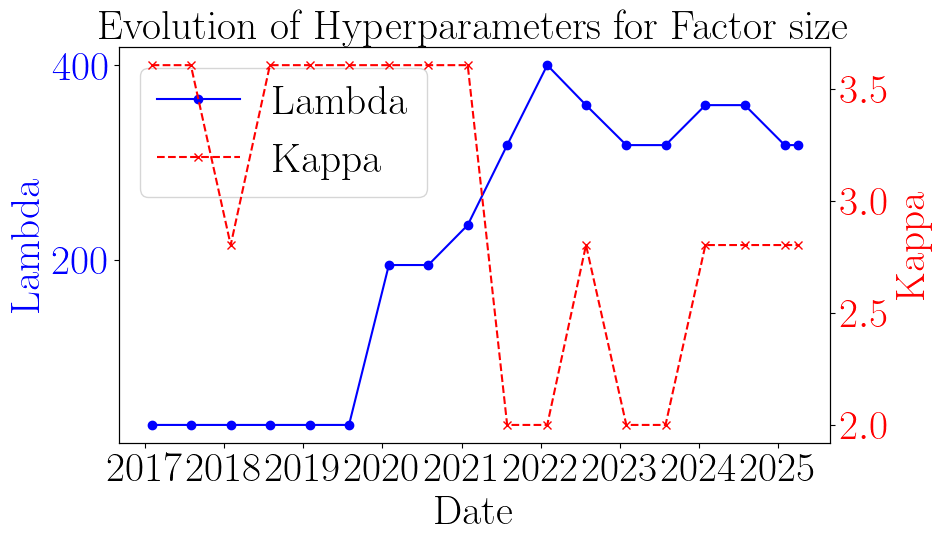

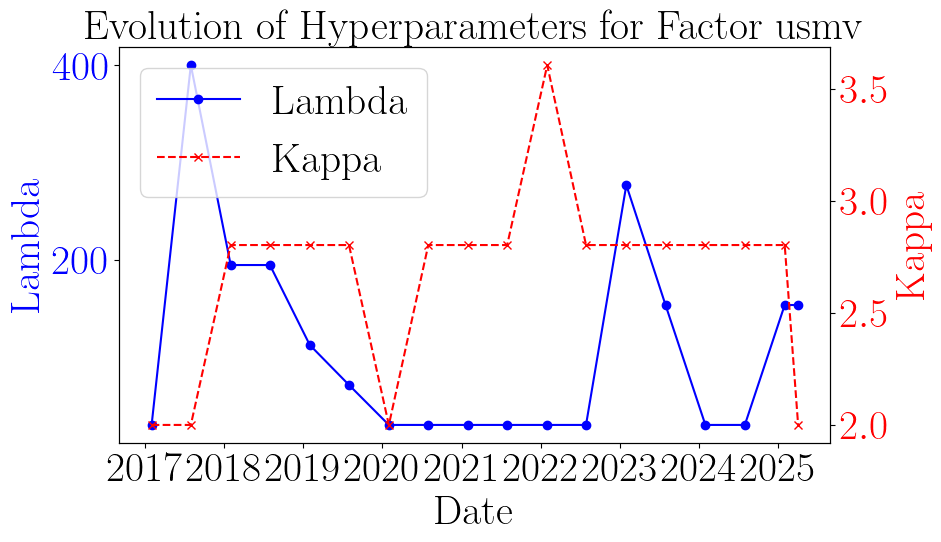

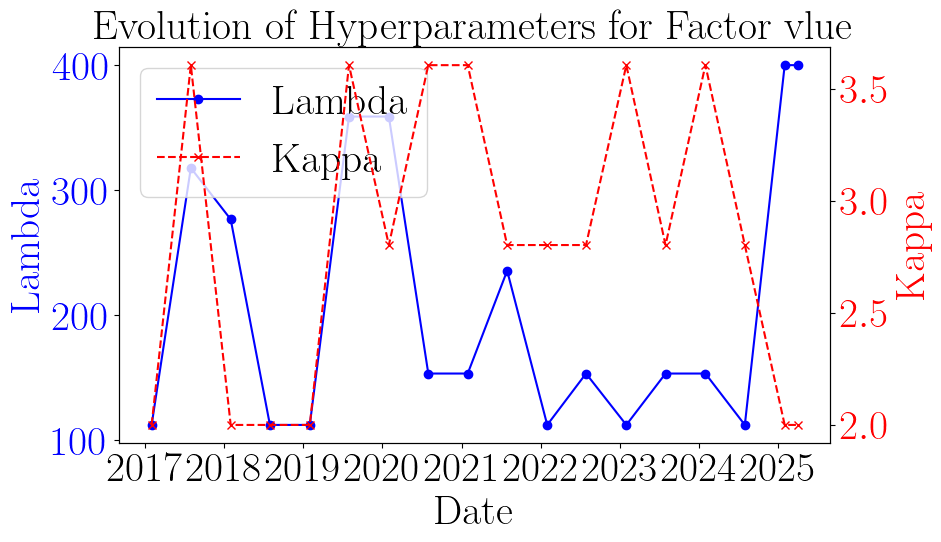

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_hyperparameters_over_time(hyperparameter_history, factor):
    """
    Plot the evolution of hyperparameters (lambda and kappa) over time for a given factor.
    
    Parameters:
      hyperparameter_history (dict): Dictionary with factor keys and lists of hyperparameter history records.
      factor (str): The name of the factor to plot.
    """
    # Convert the list of history records to a DataFrame
    df = pd.DataFrame(hyperparameter_history[factor])
    
    # Ensure the 'date' column is in datetime format and sort by date
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    
    # Set up the figure with dual y-axes for lambda and kappa
    fig, ax1 = plt.subplots(figsize=(10, 6))
    
    # Plot lambda on the primary y-axis (left)
    ax1.plot(df['date'], df['new_lambda'], marker='o', color='blue', label='Lambda')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Lambda', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    
    # Create a second y-axis to plot kappa
    ax2 = ax1.twinx()
    ax2.plot(df['date'], df['new_kappa'], marker='x', linestyle='--', color='red', label='Kappa')
    ax2.set_ylabel('Kappa', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    # Optional: Combine legends from both axes for clarity
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f"Evolution of Hyperparameters for Factor {factor}")
    plt.tight_layout()
    plt.show()

# Example usage: visualize hyperparameters for each factor
# Assume hyperparameter_history is a dictionary like:
# {
#   "factor1": [{"date": "2020-01-01", "old_lambda": ..., "new_lambda": ..., "old_kappa": ..., "new_kappa": ..., "sharpe": ...}, ...],
#   "factor2": [ ... ],
#   ...
# }
for fac in hyperparameter_history:
    plot_hyperparameters_over_time(hyperparameter_history, fac)
